# Part 2

Can the connectome give us insights about how backwards walking works?

## Part 2A
In order to adress this question, we try to find groupings of motor neurons that are recruited synergystically during backwards walking, focusing on the hind legs. 

With those clusters identified, we can make predictions about which muscles should contract together, and which movemes compose the full stepping pattern.

## Part 2B 
We can also look at the connectivity of the neurons in the connectome to see if there are any patterns that emerge. For example, are the neurons that are recruited synergystically recruited by single 'hub' neurons, or are they recruited by multiple neurons? 

# Part 2C
One we identify the clustering premotor neurons, we can compare the clustering with their direct downstream partners to see if there is some secondary overwriting logic.

In [1]:
import copy
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.sparse.linalg import norm

from vnc_networks import MANC, UID, CMatrix, Connections, params
from vnc_networks.specific_neurons import mdn_helper
from vnc_networks.utils import matrix_design


In [2]:
# ----- Directories
manc_version = "v1.2"
MDN_DIR = "MDN_project"
FIG_DIR = MANC(manc_version).get_fig_dir()
MDN_FIGS = os.path.join(FIG_DIR, MDN_DIR)
os.makedirs(MDN_FIGS, exist_ok=True)

In [ ]:
savefigs = False  # True to save figures

In [4]:
CR = MANC(manc_version)
split_mdn_vnc = mdn_helper.get_vnc_split_MDNs_by_neuropil(
    not_connected=mdn_helper.get_mdn_bodyids()
)  # exclude connections from MDNs to MDNs

Loaded VNC Connections object with MDNs split by neuropil.


# Part 2A: MDN-induced motor neuron clustering

We need to compare the clustering of motor neurons in the graph induced by MDN input vs the one that exists naturally.

In [5]:
# Analysis choices
side = "RHS"
leg = "hl"

# Hind leg, right side leg motor neurons
motor_neurons = split_mdn_vnc.get_neuron_ids(
    {
        "class_1": "motor",
        "class_2": leg,
        "side": side,
    }
)
print(f"Found {len(motor_neurons)} motor neurons for the right hind leg")


Found 65 motor neurons for the right hind leg


## Part 2A Calibration: find a consistent clustering method and parameter

In [6]:
def nb_clusters_vs_clustering_param(cparam: float, method: str):
    """
    Get the number of identified clusters as a function of the clustering parameters
    """
    vnc_matrix = split_mdn_vnc.get_cmatrix(type_="unnorm")
    # Cut it down to the motor and premotor connections
    premotor_neurons = vnc_matrix.list_upstream_neurons(motor_neurons)
    nodes = list(set(motor_neurons).union(premotor_neurons))
    vnc_matrix.restrict_nodes(nodes)
    # Clustering
    (
        _,  # clustered similarity matrix as cmatrix object
        uid_clusters,  # list of lists of uids in each cluster
        __builtins__,  # list of lists of indices in each cluster matching the clustered cmatrix
    ) = vnc_matrix.detect_clusters(
        distance="cosine_in",
        method=method,
        cluster_size_cutoff=4,
        cluster_data_type="uid",
        cluster_on_subset=motor_neurons,
        cutoff=cparam,  # kwargs for hierarchical
        inflation=cparam,  # kwargs for markov
    )
    return len(uid_clusters)


In [7]:
# Find the best cutoff parameter for markov clustering

#inflation_params = np.concatenate((np.linspace(1.2,2,5), np.linspace(3,15,13)))
#nb_clusters_markov = [nb_clusters_vs_clustering_param(ip, "markov") for ip in inflation_params]
#plt.scatter(inflation_params, nb_clusters_markov, label="markov")

Markov clustering:
Overall bell-shaped, with a long plateau at the max value nb_clusters = 7 in the range 5-13.
Values of 1 for inflation <2, nbc=4 for inflation=2, nbc=6 for nbc = 3,4 or >= 14. 

In [8]:
# Find the best cutoff parameter for hierarchical clustering

#inflation_params = np.linspace(0.1, 0.9, 9)
#nb_clusters_hier = [
#    nb_clusters_vs_clustering_param(ip, "hierarchical") for ip in inflation_params
#]
# plt.scatter(inflation_params, nb_clusters_hier, label="hierarchical")


Hierarchical clustering:
Bell-shaped as well, with cutoff value yielding a max of 8 clusters at 0.5, 7 for cutoff at 0.4 and 0.6 and less outside.

Fixing parameters for the rest of the study:
We choose the Markov clustering method that yield more stable groupings and with fewer inter-cluster connections. We pick as inflation parameter inflation=5, as it yields the clustering size oibtained over a wide range of values while minimising the connection alterations.

In [9]:
# Method choices

# Method for clustering
clustering_method = "markov" # "markov"  #'hierarchical'
# distance metric
distance_metric = "cosine_in"
# cutoff to define a cluster
cutoff = 0.4 #for hierarchical
inflation = 5 # for markov 
# minimum number of neurons in a cluster
c_min = 4

# markov clustering with inflation=3


## Part 2Aa: Control for right T3

In [10]:
vnc_matrix = split_mdn_vnc.get_cmatrix(
    type_="unnorm"
)  # the weights are the signed synapse counts, no normalisation is done


In [11]:
# Cut it down to the motor and premotor connections
premotor_neurons = vnc_matrix.list_upstream_neurons(motor_neurons)
nodes = list(set(motor_neurons).union(premotor_neurons))
vnc_matrix.restrict_nodes(nodes)

In [12]:
# cluster the motor neurons using cosine similarity on the inputs
# Clustering
(
    clustered_cmatrix,  # clustered similarity matrix as cmatrix object
    uid_clusters,  # list of lists of uids in each cluster
    index_clusters,  # list of lists of indices in each cluster matching the clustered cmatrix
) = vnc_matrix.detect_clusters(
    distance=distance_metric,
    method=clustering_method,
    cluster_size_cutoff=c_min,
    cluster_data_type="uid",
    cluster_on_subset=motor_neurons,
    cutoff=cutoff, # kwargs for hierarchical
    inflation=inflation, # kwargs for markov
)

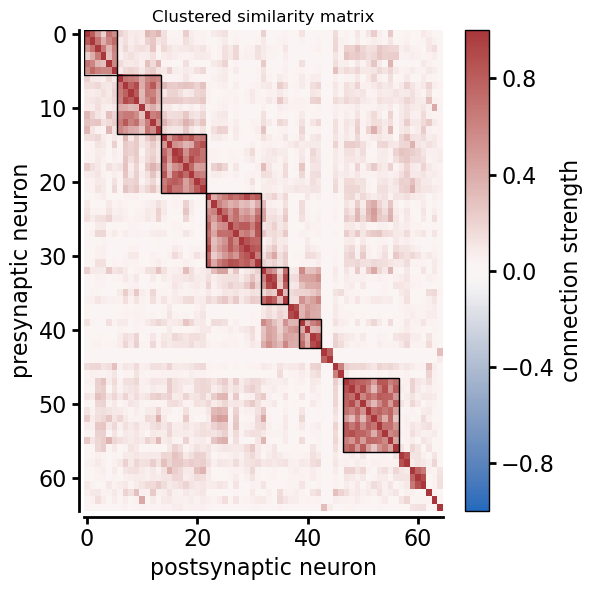

In [13]:
# Visualise the clusters

fig, ax = plt.subplots(figsize=(6, 6))
# Visualise the similarity matrix and its clusters
clustered_sim_mat = clustered_cmatrix.get_matrix().todense()
# create a matrix of zeros
mat = np.zeros((clustered_sim_mat.shape[0], clustered_sim_mat.shape[1]))
# draw the boundaries between clusters
for cluster in index_clusters:
    mat[cluster[0] : cluster[-1] + 1, cluster[0] : cluster[-1] + 1] = 1
ax, _ = clustered_cmatrix.imshow(savefig=False, ax=ax, title="Clustered similarity matrix")

#ax.imshow(mat, cmap="binary", alpha=0.4)
# Instead of shading the clusters, draw the boundaries as black boxes
for cluster in index_clusters:
    ax.add_patch(
        plt.Rectangle(
            (cluster[0] - 0.5, cluster[0] - 0.5),
            len(cluster),
            len(cluster),
            edgecolor="black",
            facecolor="none",
            lw=1,
        )
    )


if savefigs:
    plt.savefig(
        os.path.join(MDN_FIGS,"clustered_similarity_matrix_T3_R_MNs_control.pdf"),
        dpi=params.DPI, bbox_inches="tight", transparent=True
    )
plt.show()

In [14]:
# Save the clusters
# create a df with a column for the cluster number, one for the neuron uid, one 
# for the neuron bodyid, and the rest for the defined neuron properties.
neurons_in_clusters = [uid for cluster in uid_clusters for uid in cluster]

# include 'target' and 'hemilineage' as these are useful for identifying the neurons
_ = split_mdn_vnc.get_node_attribute(uid=neurons_in_clusters, attribute="target")
_ = split_mdn_vnc.get_node_attribute(uid=neurons_in_clusters, attribute="hemilineage")

# retrieve the properties of the neurons in the clusters
info_df = split_mdn_vnc.list_neuron_properties(
    neurons=neurons_in_clusters,
    input_type="uid",
)
info_df["cluster"] = -1
for i, cluster in enumerate(uid_clusters):
    info_df.loc[info_df["uid"].isin(cluster), "cluster"] = i
info_df.sort_values(by=["cluster", "uid"], inplace=True)
if savefigs:
    info_df.to_csv(
        os.path.join(MDN_FIGS, "motor_clusters_right_hind_leg_control.csv"), index=False
    )

Attribute target not found in the graph. Adding it.
Attribute hemilineage not found in the graph. Adding it.


In [15]:
# Save a more digestable version of the clustering table:

def digest_clustering_table(df):
    """
    Save a more digestable version of the clustering table:
    [cluster ; target ; count ; list_bodyids ; list_node_labels]
    """
    summary = (
        df.groupby(["cluster", "target"])
        .agg(
            count=("body_id", "count"),
            list_bodyids=("body_id", lambda x: list(x)),
            list_node_labels=("node_label", lambda x: list(x)),
        )
        .reset_index()
    )
    return summary


In [16]:
info_df_summary = digest_clustering_table(info_df)
if savefigs:
    info_df_summary.to_csv(
        os.path.join(MDN_FIGS, "motor_clusters_right_hind_leg_control_summary.csv"),
        index=False,
    )
print(info_df_summary)

    cluster                     target  count  \
0         0                        ltm      2   
1         0                 ltm1-tibia      2   
2         0                 ltm2-femur      2   
3         1             Acc. ti flexor      2   
4         1                  Ti flexor      1   
5         1                   hind leg      4   
6         1                        ltm      1   
7         2           Sternotrochanter      3   
8         2                   Tergotr.      1   
9         2                Tr extensor      2   
10        2                   hind leg      2   
11        3             Acc. tr flexor      3   
12        3                  Tr flexor      7   
13        4  Sternal posterior rotator      3   
14        4                   hind leg      2   
15        5                Fe reductor      1   
16        5   Pleural remotor/abductor      2   
17        5  Sternal posterior rotator      1   
18        6             Acc. ti flexor      4   
19        6         

Inflation == 5 
We see 7 clusters in the control case. 
- cluster 0: long tendon only
    => grip, tensening of the tarsus
- cluster 1: (acc) tibia flexor, long tendon
    => flex femur-tibia joint, stiffen tarsus
- cluster 2: sternotrochanter, tergotrochanter, trochanter extensor
    => extension of the coxa-trochanter joint
- cluster 3: (acc.) tr flexor
    => flexion of the coxa-trochanter joint

dep on threshold, 4 & 5 could be grouped together
- cluster 4: Sternal posterior rotator
- cluster 5: Sternal posterior rotator, Pleural remotor/abductor, Fe reductor

- cluster 6: (cc) tibia flexor
    => flex femur-tibia joint

Clusters 1 and 6 seem to target similar movements, but they are quite different in their connectivity

Inflation == 13
We see 7 clusters in the control case. 
- cluster 0: long tendon only
    => grip, tensening of the tarsus
- cluster 1: (acc) tibia flexor, long tendon
    => flex femur-tibia joint, stiffen tarsus
- cluster 2: sternotrochanter, tergotrochanter, trochanter extensor
    => extension of the coxa-trochanter joint
- cluster 3: (acc.) tr flexor
    => flexion of the coxa-trochanter joint
    
dep on threshold, 4 & 5 could be grouped together
- cluster 4: Sternal posterior rotator
- cluster 5: Pleural remotor/abductor, Fe reductor
- cluster 6: (acc) tibia flexor
    => flex femur-tibia joint


Observation: with the exception of one or 2 motor neurons, clusters remain practically identical between the inflation values 5 and 13. This method seems to pull out structures that are stable and robust to parameter fine tuning.

## Part 2Ab: MDN circuit for right T3

In [17]:
# Select the MDN subdivisions that have synapses in the hind right leg
input_neurons = mdn_helper.get_subdivided_mdns(
    VNC=split_mdn_vnc,
    neuropil=leg,
    #side=side,
)

In [18]:
# Keep only the connections that create a path from source to target

subnetwork = split_mdn_vnc.subgraph_from_paths(  # copy operation
    source=input_neurons,
    target=motor_neurons,
    n_hops=2,  # within 2 hops, i.e. only 1 interneuron
    keep_edges="intermediate",  # keep the connections between the interneurons
    # as well, but not between source neurons or between target neurons
    # can also be 'direct' (only direct paths) or 'all' (all connections between
    # recruited nodes)
)

Attribute class_1 not found in the graph. Adding it.


In [19]:
# Get the connectivity matrix

subnetwork_matrix = subnetwork.get_cmatrix(type_="unnorm")
# Cut it down to the motor and premotor connections
premotor_neurons = subnetwork_matrix.list_upstream_neurons(motor_neurons)
nodes = list(set(motor_neurons).union(premotor_neurons))
subnetwork_matrix.restrict_nodes(nodes)


In [20]:
# cluster the motor neurons using cosine similarity on the inputs

(
    sub_clustered_cmatrix,  # clustered similarity matrix as cmatrix object
    sub_uid_clusters,  # list of lists of uids in each cluster
    sub_index_clusters,  # list of lists of indices in each cluster matching the clustered cmatrix
) = subnetwork_matrix.detect_clusters(
    distance=distance_metric,
    method=clustering_method,
    cluster_size_cutoff=c_min,
    cluster_data_type="uid",
    cluster_on_subset=motor_neurons,
    cutoff=cutoff, # kwargs for hierarchical
    inflation=inflation, # kwargs for markov
)

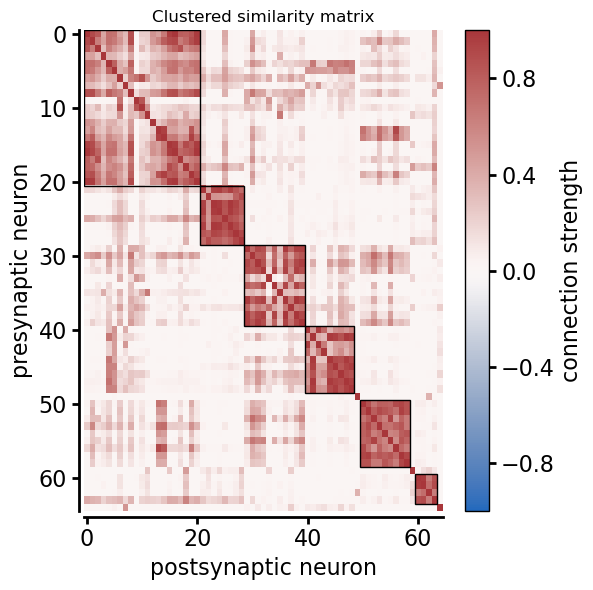

In [21]:
# Visualise the similarity matrix and its clusters

fig, ax = plt.subplots(figsize=(6, 6))
sub_clustered_sim_mat = sub_clustered_cmatrix.get_matrix().todense()
# create a matrix of zeros
mat = np.zeros((sub_clustered_sim_mat.shape[0], sub_clustered_sim_mat.shape[1]))
# draw the boundaries between clusters
for cluster in sub_index_clusters:
    mat[cluster[0] : cluster[-1] + 1, cluster[0] : cluster[-1] + 1] = 1
_ = sub_clustered_cmatrix.imshow(
    savefig=False, ax=ax, title="Clustered similarity matrix"
)
# ax.imshow(mat, cmap="binary", alpha=0.4)
# Instead of shading the clusters, draw the boundaries as black boxes
for cluster in sub_index_clusters:
    ax.add_patch(
        plt.Rectangle(
            (cluster[0] - 0.5, cluster[0] - 0.5),
            len(cluster),
            len(cluster),
            edgecolor="black",
            facecolor="none",
            lw=1,
        )
    )

if savefigs:
    fig.savefig(
        os.path.join(
            MDN_FIGS, "clustered_similarity_matrix_T3_R_MNs_MDN_input.pdf"
        ),
        dpi=params.DPI,
        bbox_inches="tight",
        transparent=True,
    )

plt.show()


In [22]:
# Save the clusters
# create a df with a column for the cluster number, one for the neuron uid, one
# for the neuron bodyid, and the rest for the defined neuron properties.
neurons_in_subclusters = [uid for cluster in sub_uid_clusters for uid in cluster]

sub_info_df = split_mdn_vnc.list_neuron_properties(
    neurons=neurons_in_subclusters,
    input_type="uid",
)
sub_info_df["cluster"] = -1
for i, cluster in enumerate(sub_uid_clusters):
    sub_info_df.loc[sub_info_df["uid"].isin(cluster), "cluster"] = i
sub_info_df.sort_values(by=["cluster", "uid"], inplace=True)
if savefigs:
    sub_info_df.to_csv(
        os.path.join(MDN_FIGS, "motor_clusters_right_hind_leg_MDN_input.csv"),
        index=False,
    )


In [23]:
sub_info_df_summary = digest_clustering_table(sub_info_df)
if savefigs:
    sub_info_df_summary.to_csv(
        os.path.join(MDN_FIGS, "motor_clusters_right_hind_leg_MDN_input_summary.csv"),
        index=False,
    )
print(sub_info_df_summary)


    cluster                     target  count  \
0         0             Acc. ti flexor      4   
1         0             Acc. tr flexor      1   
2         0   Pleural remotor/abductor      1   
3         0                  Ti flexor      1   
4         0                  Tr flexor      1   
5         0                   hind leg      8   
6         0                        ltm      3   
7         0                 ltm1-tibia      2   
8         1           Sternotrochanter      3   
9         1                   Tergotr.      1   
10        1                Tr extensor      2   
11        1                   hind leg      2   
12        2             Acc. ti flexor      1   
13        2             Acc. tr flexor      2   
14        2                Ti extensor      2   
15        2                  Tr flexor      6   
16        3                Fe reductor      2   
17        3   Pleural remotor/abductor      1   
18        3           Sternal adductor      1   
19        3  Sternal

Inflation == 5:
6 observed clusters:
- cluster 0: long tendon tension, tibia flexion and trochanter flexion 
    => pulling from back to front  with grip?
- cluster 1: trochanter extensor, sternotrochnater, tergotrochanter
    => outwards extension?
- cluster 2: trochanter flexor (8), tibia extensor (2), acc ti flexor (1)
    => start of swing?
- cluster 3: Fe reductor, sternal adductor, sternal posterior rotator, pleural remotor/abductor
    => outwards lateral component?
- cluster 4: tibia flexor, long-tendon (femur)
    => end of stance?
- cluster 5: sternal anterior rotator
    => inwards lateral movement?

Inflation == 13:
6 observed clusters:
- cluster 0: long tendon tension, acc tibia flexion and trochanter flexion 
    => pulling from back to front  with grip?
- cluster 1: trochanter extensor, sternotrochnater, tergotrochanter
    => outwards extension?
- cluster 2: trochantor flexor (8), tibia extensor (2)
    => start of swing?
- cluster 3: Fe reductor, sternal adductor, sternal posterior rotator, pleural remotor/abductor
    => outwards lateral component?
- cluster 4: tibia flexor
    => end of stance?
- cluster 5: (acc) tibia flexor
    => end of stance?

The main difference comes from the fact that inflation==13 assigns fewer neurons to clusters than inflation==5, meaning that the small cluster 5 in the former is not detected anymore, and the cluster 4 is split. The main grouping remain identical however, with the same gestures being described. We will keep inflation==5 as parameter since it covers most of the neurons recruited.

## Part 2Ac: compare the different clusterings

We get a set of clusters fo reith er the agnostic of the MDN-induced graph.
We want to see how much they overlap or differ to see whether only a subset gets recruited, or if the clusters are completely overwritten.

In order to do that we create a matrix of cluster numbers for each method on each axis, and the entries correspond to the number of overlapping entries normalised by the agnostic clusters. If there are strong components (close to 1) then the clusters are mostly kept, if the matrix is noisy and distributed then clusters get overwritten.

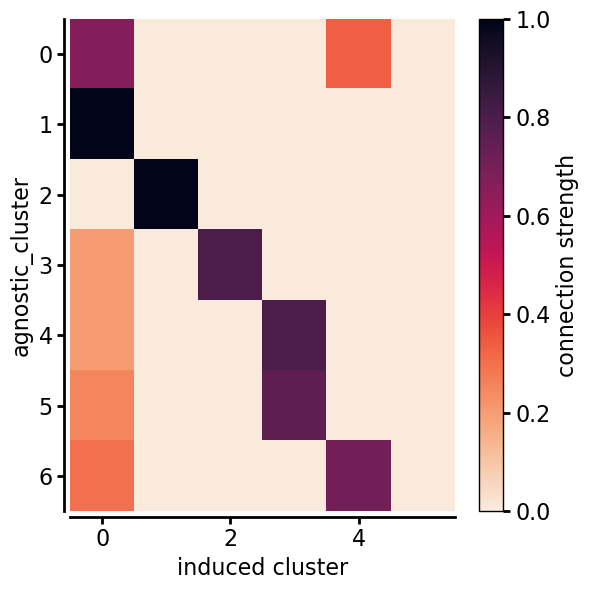

In [24]:
# info_df: agnostic
agnostic_clusters = np.unique(info_df["cluster"])
# sub_info_df: MDN-induced
induced_clusters = np.unique(sub_info_df["cluster"])

meta_mat = np.zeros(
    (len(agnostic_clusters), len(induced_clusters))
)
for i in agnostic_clusters:
    candidates = info_df.loc[info_df["cluster"] == i]["uid"].values
    for j in induced_clusters:
        selected = sub_info_df.loc[
            (sub_info_df["cluster"] == j) & (sub_info_df["uid"].isin(candidates))
        ]
        meta_mat[i, j] = len(selected) / len(candidates) # relative to agnostic clusters

fig, ax = plt.subplots(1,1,figsize=(6,6))
matrix_design.imshow(
    meta_mat,
    title="",
    ylabel="agnostic_cluster",
    xlabel="induced cluster",
    vmin=0,
    vmax=1,
    cmap=params.red_heatmap,
    ax=ax,
)


if savefigs:
    fig.savefig(
        os.path.join(MDN_FIGS, "clustering_comparison_agnostic_vs_MDN_induced.pdf"),
        dpi=params.DPI,
        bbox_inches="tight",
    )

plt.show()

It looks like 2 clusters result from recombinations, whereas the 4 others are mostly identical.
- Cluster 0 from the MDN-induced graph appears to be the combination of neurons from multiple different agnostic clusters
- Clusters 1 to 4 are predominantly identical to the agnostic clusters, with cluster 3 being a combination of two of them.
- Cluster 5 combines neurons that were not part of a cluster previously

# Part 2B: premotor connectivity analysis

## Part 2Ba: contribution of individual premotor neurons

We want to see which premotor neurons contribute to the recruitment of the motor neurons in the clusters we identified in Part 2A.

In order to do so, we define a metric `m1` that quantifies the unique contribution of a premotor neuron to the recruitement of a cluster as following:
- sum the absolute values of the weights (i.e. synapse count) of the edges between the premotor neuron and the motor neurons in the cluster
- substract the sum of the absolute values of the weights of the edges between the premotor neuron and the motor neurons not in the cluster, scaled by a discount factor `alpha` (e.g. nb. of motor neurons in the cluster divided by the number of remaining motor neurons, such that if all connections are equal the score is 0)

In [25]:
def m1(
        cmat: CMatrix, # connectivity matrix
        source: UID, # premotor neuron
        targets: list[UID], # neurons in cluster
        motor_neurons: list[UID], # all motor neurons
        ):
        """
        M1 metric as defined above.
        """
        m1 = 0

        # Positive contributions to the targets
        direct_mat = cmat.get_matrix(
                row_ids=[source],
                column_ids=targets,
                input_type="uid",
                )
        direct_mat = abs(direct_mat)
        m1 += direct_mat.sum()

        # Negative contributions to the targets
        other_targets = [mn for mn in motor_neurons if mn not in targets]
        other_connections = cmat.get_matrix(
                row_ids = [source],
                column_ids = other_targets,
                input_type = "uid",
        )
        other_connections = abs(other_connections)

        # alpha: #targets/#non targets
        alpha = len(targets) / len(other_targets)
        m1 -= alpha * other_connections.sum()

        return m1
        

In [26]:
# Load the motor neuron clusters

mdn_based_clustering_df = sub_info_df.copy() # If no saving to file
# mdn_based_clustering_df = pd.read_csv( # If saving to file 
#     os.path.join(MDN_FIGS, "motor_clusters_right_hind_leg_control.csv")
# )
def get_uids_from_cluster(cluster_number, df):
    return df[df["cluster"] == cluster_number]["uid"].values

In [27]:
# Add nt_type to read node properties
_ = split_mdn_vnc.get_node_attribute(uid=neurons_in_clusters, attribute="nt_type")


Attribute nt_type not found in the graph. Adding it.


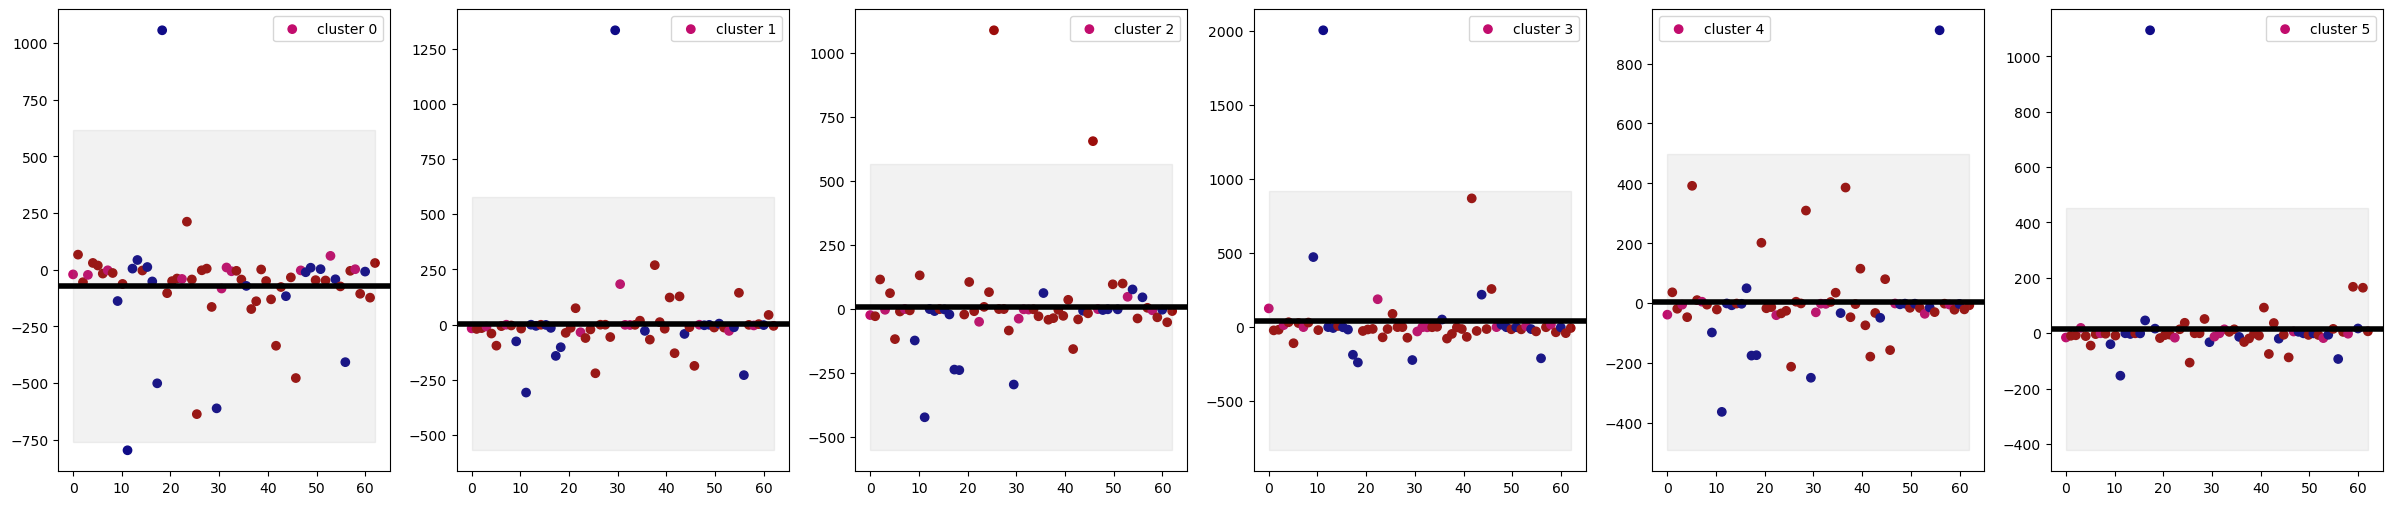

In [28]:
# visualise contribution for each cluster
clusters = np.unique(mdn_based_clustering_df['cluster'].values)
nb_clusters = len(clusters)

pmn_df = pd.DataFrame()

fig, axs = plt.subplots(1, nb_clusters, figsize=(30,6))

for i, c in enumerate(clusters):
    c_i = get_uids_from_cluster(c, mdn_based_clustering_df)
    c1_m1 = [
        m1(cmat=subnetwork_matrix, source=pmn, targets=c_i, motor_neurons=motor_neurons)
        for pmn in premotor_neurons
        ]
    x = np.linspace(0, len(c1_m1), len(c1_m1))
    nts = split_mdn_vnc.get_node_attribute(uid=premotor_neurons,attribute='nt_type')
    colors = [params.NT_TYPES[nt]["color"] for nt in nts]
    axs[i].scatter(x,c1_m1, color = colors, marker = 'o', linestyle='None', label=f'cluster {c}')
    # get error shading
    std_i = 3*np.std(c1_m1) # 99th percentile
    mean_i = np.mean(c1_m1)
    axs[i].axhline(y=mean_i, linewidth=4, color='k')
    x = np.linspace(0, len(c1_m1), len(c1_m1))
    axs[i].fill_between(x,mean_i-std_i, mean_i+std_i, alpha=0.1, color='grey')
    axs[i].legend()

    # save the neurons that contribute significantly
    significant_neurons = [
        node for i, node in enumerate(premotor_neurons)
        if c1_m1[i] > mean_i + std_i
        ]
    info = split_mdn_vnc.list_neuron_properties(
        neurons=significant_neurons,
        input_type="uid",
    )
    info["m1 score"] = info["uid"].apply(
        lambda x: m1(
            cmat=subnetwork_matrix,
            source=x,
            targets=c_i,
            motor_neurons=motor_neurons,
        )
    )
    info["cluster connecting to"] = c
    info.sort_values(by="m1 score", ascending = False, inplace=True)
    pmn_df = pd.concat([pmn_df,info])
    

if savefigs:
    plt.savefig(
        os.path.join(MDN_FIGS, "motor_clusters_right_hind_leg_MDN_premotor_hubs.pdf"),
        dpi=params.DPI,
        bbox_inches="tight",
    )
plt.show()


In [29]:
print(pmn_df)

if savefigs:
    pmn_df.to_csv(
        os.path.join(MDN_FIGS, "motor_clusters_right_hind_leg_MDN_premotor_hubs.csv"),
        index=False,
    )

       body_id node_label    class_1 node_class     target hemilineage  \
9595     10380   IN09A002  intrinsic  intrinsic  LegNpT3_R         09A   
15581    10425   IN13B006  intrinsic  intrinsic  LegNpT3_R         13B   
11907    11325   IN21A010  intrinsic  intrinsic  LegNpT3_R         21A   
19455    10677   INXXX464  intrinsic  intrinsic  LegNpT3_R         TBD   
7024     10372   IN19A003  intrinsic  intrinsic  LegNpT3_R         19A   
21924    10513   INXXX053  intrinsic  intrinsic  LegNpT3_R         TBD   
9431     11819   IN08A006  intrinsic  intrinsic  LegNpT3_R         08A   

             nt_type    uid     m1 score  cluster connecting to  
9595            gaba   9595  1056.136364                      0  
15581           gaba  15581  1334.263158                      1  
11907  acetylcholine  11907  1089.962963                      2  
19455  acetylcholine  19455   656.111111                      2  
7024            gaba   7024  2004.071429                      3  
21924      

With the exception of one cluster that is significantly driven by 2 excitatory neurons, the other 5 clusters have as sole out-of-distribution contributors a single gaba-ergic neuron. There are clear hubs driving those movements, and we can hypothesise that what matters is a cycle desinhibition.

## Part 2Bb: Control that connectivity of different nt types is significant

In [30]:
vanilla_vnc = Connections(CR=CR) # no neuron splitting or anything

Attribute class_1 not found in the graph. Adding it.


In [31]:
all_neurons = vanilla_vnc.get_nodes()
df_degree = pd.DataFrame({'uid':all_neurons})
df_degree["nt_type"] = vanilla_vnc.get_node_attribute(
    uid=all_neurons, attribute="nt_type"
)
df_degree = df_degree[
    (df_degree["nt_type"] != "None")
    & (df_degree["nt_type"] != "unknown")
    & (df_degree["nt_type"] != "unclear")
]
df_degree["out_degree"] = df_degree["uid"].apply(
    lambda x: vanilla_vnc.get_out_degree(x)
    )
df_degree["in_degree"] = df_degree["uid"].apply(
    lambda x: vanilla_vnc.get_in_degree(x)
)

Attribute nt_type not found in the graph. Adding it.


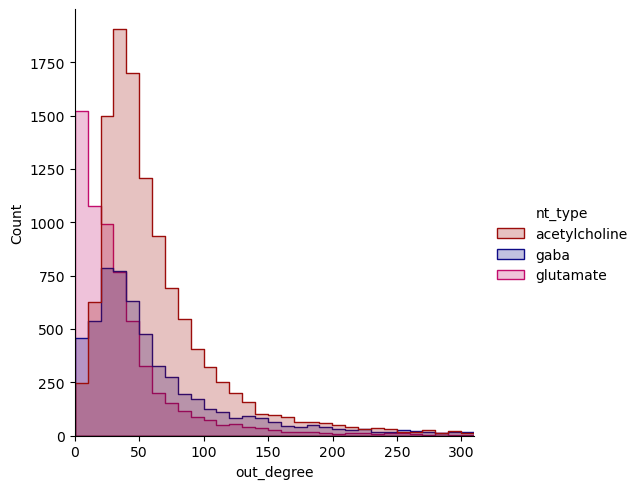

In [32]:
# 99th percentile of out_degree
p99 = np.percentile(df_degree["out_degree"].values, q=99)

# binning
bin_size = 10

nt_types = np.unique(df_degree["nt_type"])
palette = [params.NT_TYPES[nt]["color"] for nt in nt_types]

grid = sns.displot(
    data=df_degree,
    x="out_degree",
    hue="nt_type",
    kind="hist",
    element="step",
    palette=palette,
    binwidth=bin_size,
)
grid.ax.set_xlim([0, p99])

if savefigs:
    plt.savefig(
        os.path.join(MDN_FIGS, "vnc_out_degree_per_nt_type.pdf"),
        dpi=params.DPI,
        bbox_inches="tight",
    )

plt.show()



There are more excitatory than gabaergic neurons with a high out degree, therefore finding gabaergic neurons as being the main hubs is not statistically expected.

Another way to look at this is to estimate the conditional probability distribution of getting a neuron with a certain nt_type given it's degree.
`P(nt = n | deg = d) = P(deg = d | nt = n) * P(nt = n) / P(deg = d)`
with all these probabilities being given by estimates on the data.

In [33]:
def P_deg(d:int, df: pd.DataFrame, bin = 5):
    """
    Estimated probability of getting a neuron with out degree d.
    """
    data = df.loc[(df["out_degree"] >= d - bin) & (df["out_degree"] < d + bin)]
    return len(data) / len(df)

def P_nt(n: str, df: pd.DataFrame):
    """
    Estimated probability of getting a neuron with nt_type n.
    """
    data = df.loc[df["nt_type"] == n]
    return len(data) / len(df)

def P_deg_given_nt(d: int, n: str, df: pd.DataFrame, bin=5):
    """
    Estimated conditional probability of getting a neuron of degree d given its nt_type.
    """
    data = df.loc[
        (df["out_degree"] >= d - bin)
        & (df["out_degree"] < d + bin)
        & (df["nt_type"] == n)
    ]
    nt_specific_df = df.loc[df["nt_type"] == n]
    return len(data) / len(nt_specific_df)

def P_nt_given_deg(n: str, d: int, df: pd.DataFrame, bin=5):
    """
    Computed conditional probability of getting a neuron of degree d given its nt_type.
    """
    proba = (
        P_deg_given_nt(d=d, n=n, df=df, bin=bin)
        * P_nt(n=n, df=df)
        / P_deg(d=d, df=df, bin=bin)
    )
    return proba

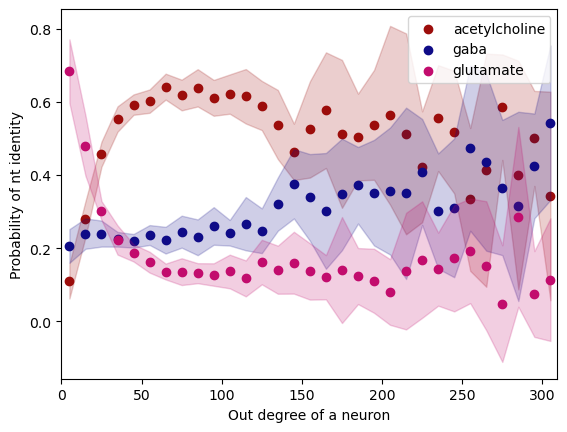

In [34]:
nt_types = np.unique(df_degree["nt_type"])

bin_e = bin_size//2
max_x = int(p99 // bin_size) * bin_size + bin_e
nb_x =(max_x - bin_e) // bin_size + 1
X = np.linspace(bin_e, max_x, nb_x)

defined_degrees = np.unique(df_degree["out_degree"].values)

fig, axs = plt.subplots(1, 1)

for i, nt in enumerate(nt_types):
    # Estimate the probability with binned data
    conditional_proba = [P_nt_given_deg(nt, d, df_degree, bin=bin_e) for d in X]

    # Error bar estimation on std
    error_bar_up, error_bar_low = [], []
    for j, x in enumerate(X):
        degrees = [d for d in defined_degrees if ((d >= x - bin_e) & (d < x + bin_e))]
        individual_cps = [P_nt_given_deg(nt, d, df_degree, bin=0.5) for d in degrees]
        error_bar_up.append(conditional_proba[j] + np.std(individual_cps))
        error_bar_low.append(conditional_proba[j] - np.std(individual_cps))

    # plot results
    color = params.NT_TYPES[nt]["color"]
    axs.scatter(X, conditional_proba, label=nt, c=color)
    axs.fill_between(
        X,
        error_bar_low,
        error_bar_up,
        alpha=0.2,
        color=color,
    )


axs.legend()
axs.set_xlim([0, p99])
axs.set_xlabel("Out degree of a neuron")
axs.set_ylabel("Probability of nt identity")

if savefigs:
    plt.savefig(
        os.path.join(MDN_FIGS, "conditional_proba_nt_type_vs_out_degree_full_vnc.pdf"),
        dpi=params.DPI,
        bbox_inches="tight",
    )

plt.show()

There is no degree range for which picking a high degree neuron is more likely to return a gabaergic neuron. The fact that we do get that when lookng at the MDN-induced motor neuron clustering in T3 is therefore a specific pattern likely to have its importance.

# Part 2C: special premotor to motor neurons

We want to compare the clustering with the direct downstream partners of the special premotor neurons that we have just identified, and see if there is some secondary overwriting logic.

## Part 2Ca: quantify the overlap between the clusters and the direct downstream partners

In [35]:
def metric_complete_specific(
        cm: CMatrix,
        premns:list[UID],
        mns_in_cluster:list[UID],
        ):
    """
    Evaluate how much the direct downstream partners of a premotor neuron overlaps 
    with the corresponding clustering.
    """
    cmat = copy.deepcopy(cm)
    cmat.restrict_rows(premns)
    # neurons downtream of the premotor neurons
    downstream_neurons = cmat.list_downstream_neurons(premns)
    downstream_mns = [n for n in downstream_neurons if n in motor_neurons]

    # neurons both downstream and in cluster
    common_neurons = [n for n in downstream_mns if n in mns_in_cluster]

    # metrics based on number of connections
    nb_specific = len(common_neurons) / len(downstream_mns)
    nb_complete = len(common_neurons) / len(mns_in_cluster)

    # metrics based on connection strengths
    intersection_strength = np.sum(
        np.absolute(cmat.get_matrix(row_ids=premns, column_ids=common_neurons))
    )
    
    specific_strength = intersection_strength / np.sum(
        np.absolute(cmat.get_matrix(row_ids=premns, column_ids=downstream_mns))
    )
    complete_strength = intersection_strength / np.sum(
        np.absolute(cmat.get_matrix(row_ids=premns, column_ids=mns_in_cluster))
    )

    return {
        "nb_specific": nb_specific,
        "nb_complete": nb_complete,
        "specific_strength": specific_strength,
        "complete_strength": complete_strength,
    }

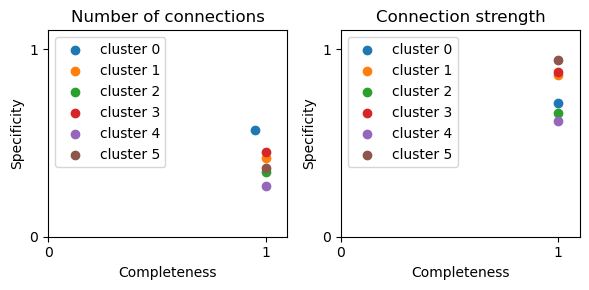

In [36]:
cluster_list = np.unique(pmn_df['cluster connecting to'])
fig, axs = plt.subplots(1, 2, figsize=(6,3))
# left plot: nb_specific vs nb_complete
# right plot: specific_strength vs complete_strength

for c in cluster_list:
    premn = pmn_df.loc[pmn_df['cluster connecting to'] == c]["uid"].values
    mns_in_cluster = sub_info_df.loc[sub_info_df['cluster'] == c]["uid"].values
    metrics = metric_complete_specific(
        cm=subnetwork_matrix, premns=premn, mns_in_cluster=mns_in_cluster
    )
    axs[0].scatter(metrics["nb_complete"], metrics["nb_specific"], label=f'cluster {c}')
    axs[1].scatter(metrics["complete_strength"], metrics["specific_strength"], label=f'cluster {c}')

axs[0].set_title("Number of connections")
axs[1].set_title("Connection strength")

for ax in axs:
    ax.set_xlabel("Completeness")
    ax.set_ylabel("Specificity")
    ax.set_xlim([0, 1.1])
    ax.set_xticks([0,1])
    ax.set_ylim([0, 1.1])
    ax.set_yticks([0,1])
    ax.legend(loc='upper left')
plt.tight_layout()

if savefigs:
    plt.savefig(
        os.path.join(MDN_FIGS, "completeness_vs_specificity_cluster_premns_MDN.pdf"),
        dpi=params.DPI,
        bbox_inches="tight",
    )


There is quite some overlap in the downstream partners of the special premotor neurons and the motor neurons in the clusters we identified. This suggests that the special premotor neurons are indeed the main drivers of the movements we identified in Part 2A. The overlap between the neurons downstream of one of the premotor neurons is quite high in terms of numebrs, with only around 30% specificity. This increases to around 80% however when we account for connection weights. The means that we could lool at those clusters as being simply the neurons strongly innervated by the special premotor neurons.

## Part 2Cb: visualise the overlap

Plot the connectivity of the special premotor neurons to the motor neurons in the clusters we identified.
Each row corresponds to a special premotor neuron, and each column to a motor neuron. The motor neurons are ordered by cluster.

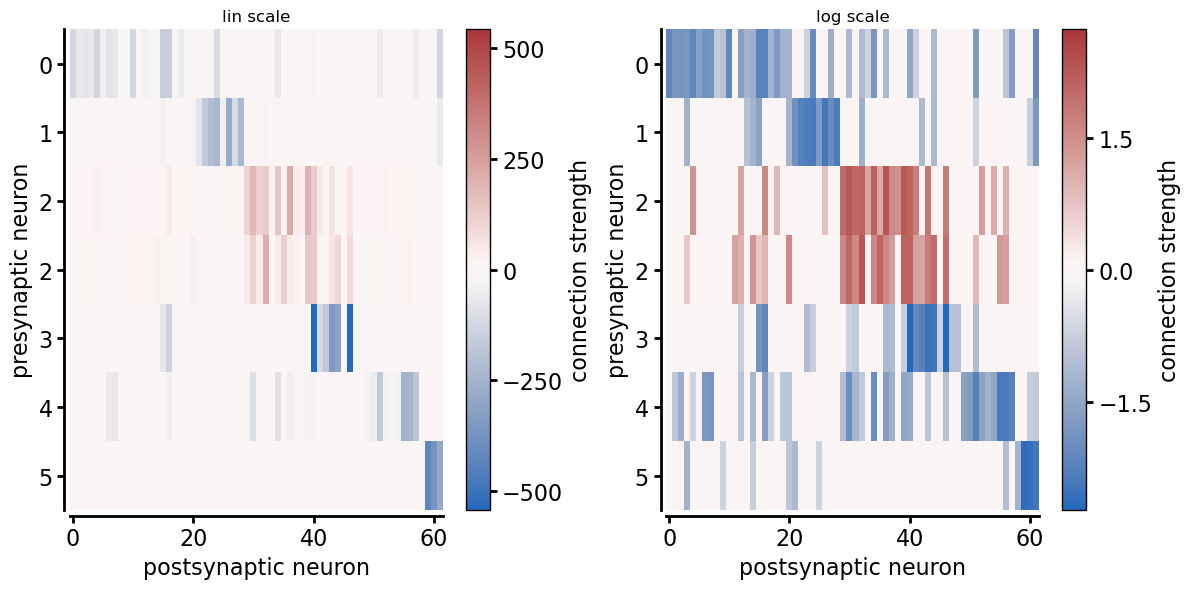

In [37]:
# make sur that the premotor neurons are in the same order as the clusters
pmn_df.sort_values(by="cluster connecting to", inplace=True)
premns = pmn_df["uid"].values
# get the motor neurons in the same order as the clusters
sub_info_df.sort_values(by="cluster", inplace=True)
mns_in_clusters = sub_info_df["uid"].values

cmat = split_mdn_vnc.get_cmatrix(type_="unnorm")
cmat.restrict_from_to(premns, mns_in_clusters, keep_initial_order=False)

_, axs = plt.subplots(1, 2, figsize=(12, 6))
_ = cmat.imshow(ax=axs[0], savefig=False, title="lin scale")
_ = cmat.imshow(ax = axs[1],  savefig=False, log_scale=True, title="log scale")

for ax in axs:
    ax.set_yticks(np.arange(len(premns)))
    ax.set_yticklabels(pmn_df["cluster connecting to"].values)
plt.tight_layout()


if savefigs:
    plt.savefig(
        os.path.join(MDN_FIGS, "special_premotor_to_motor_connections_MDN.pdf"),
        dpi=params.DPI,
        bbox_inches="tight",
    )

plt.show()